## Data Understanding and Pre-Processing

### Intoduction ###
For our project we will be exploring stock prices for 10 companies over 10 years. Our goal for this project will be to use clustering and regression to make predictions like prices and returns on stock market data. Some questions are any of the companies stock prices related as in when one drops do they both drop or when one is up does the other go up. We also want to clusters dates together using clustering to figure out if there are any trends related to time of the year or day of the week when it comes to stock prices. 

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor

In [126]:
df = pd.read_csv('data.csv')
df.head()

,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Company     25160 non-null  object
 1   Date        25160 non-null  object
 2   Close/Last  25160 non-null  object
 3   Volume      25160 non-null  int64 
 4   Open        25160 non-null  object
 5   High        25160 non-null  object
 6   Low         25160 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


dataset info says we should have 5 string types, 1 int type, and 1 datetime type. i think we should have 1 string type (company), 1 int type (volume), 1 datetime, and the rest should be floats (monetary values).

In [128]:
df.columns = df.columns.str.lower()

Preprocessing is the first things that we did to make sure our models will come out the best. The first thing that we did is remove the money signs from our columnns that contain money so that they are easier to use for calculations. Following that we did checks to make sure that we knew all the information about our data. Being that there were no null values we didn't have to do much else. 

In [129]:
df = df.rename(columns={'close/last':'close'})

In [130]:
df['company'] = df['company'].astype('string')

df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
                            
money_cols = ['close', 'open', 'high', 'low']
for col in money_cols:
    df[col] = df[col].replace(r'[\$,]', '', regex=True).astype(float)

df.head()

,company,date,close,volume,open,high,low
0,AAPL,2023-07-17,193.99,50520160,191.90,194.3200,191.81
1,AAPL,2023-07-14,190.69,41616240,190.23,191.1799,189.63
2,AAPL,2023-07-13,190.54,41342340,190.50,191.1900,189.78
3,AAPL,2023-07-12,189.77,60750250,189.68,191.7000,188.47
4,AAPL,2023-07-11,188.08,46638120,189.16,189.3000,186.60


making sure everything parsed without error (differences in formatting)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   company  25160 non-null  string        
 1   date     25160 non-null  datetime64[ns]
 2   close    25160 non-null  float64       
 3   volume   25160 non-null  int64         
 4   open     25160 non-null  float64       
 5   high     25160 non-null  float64       
 6   low      25160 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 1.3 MB


In [132]:
df.duplicated().sum()

np.int64(0)

In [133]:
df["company"].value_counts()

company
AAPL    2516
SBUX    2516
MSFT    2516
CSCO    2516
QCOM    2516
META    2516
AMZN    2516
TSLA    2516
AMD     2516
NFLX    2516
Name: count, dtype: Int64

there are 10 companies and an equal amount of market data for each

In [134]:
# sort data in chronological order by company
df = df.sort_values(by=['company', 'date'])
df.head(10)

,company,date,close,volume,open,high,low
2515,AAPL,2013-07-18,15.4199,218632537,15.4779,15.5311,15.3789
2514,AAPL,2013-07-19,15.1768,268548901,15.4679,15.4993,15.1554
2513,AAPL,2013-07-22,15.2254,207648981,15.3379,15.3482,15.1953
2512,AAPL,2013-07-23,14.9639,354477618,15.2143,15.2486,14.9539
2511,AAPL,2013-07-24,15.7325,591624923,15.6761,15.8782,15.5450
2510,AAPL,2013-07-25,15.6607,229432412,15.7393,15.7643,15.5646
2509,AAPL,2013-07-26,15.7496,200082264,15.5464,15.7514,15.5121
2508,AAPL,2013-07-29,15.9925,248025441,15.7429,16.0711,15.7214
2507,AAPL,2013-07-30,16.1900,308960556,16.0700,16.3268,16.0439
2506,AAPL,2013-07-31,16.1618,322499391,16.2496,16.3337,16.0511


## Feature Engineering

Following our pre processing we did some feature engineering to give us some more information about our data. Below you can see some of the features that we make that will help us later when creating our models. 

In [135]:
# difference between day's close and open prices
df['price_change'] = df['close']-df['open']
# percent change
df['price_change_pct'] = ((df['close'] - df['open']) / df['open']) * 100

# difference between day's highest and lowest prices (volatility)
df['daily_range'] = df['high'] - df['low']

# difference (gap) between current and previous close prices
df['prev_close'] = df.groupby('company')['close'].shift(1)
df['gap'] = df['open'] - df['prev_close']

# day/month/year
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Calculate dailyt returns and volatility
df['daily_return_pct'] = df.groupby('company')['close'].pct_change() * 100
df['volatility_5d'] = df.groupby('company')['daily_return_pct'].rolling(window=5).std().reset_index(level=0, drop=True)

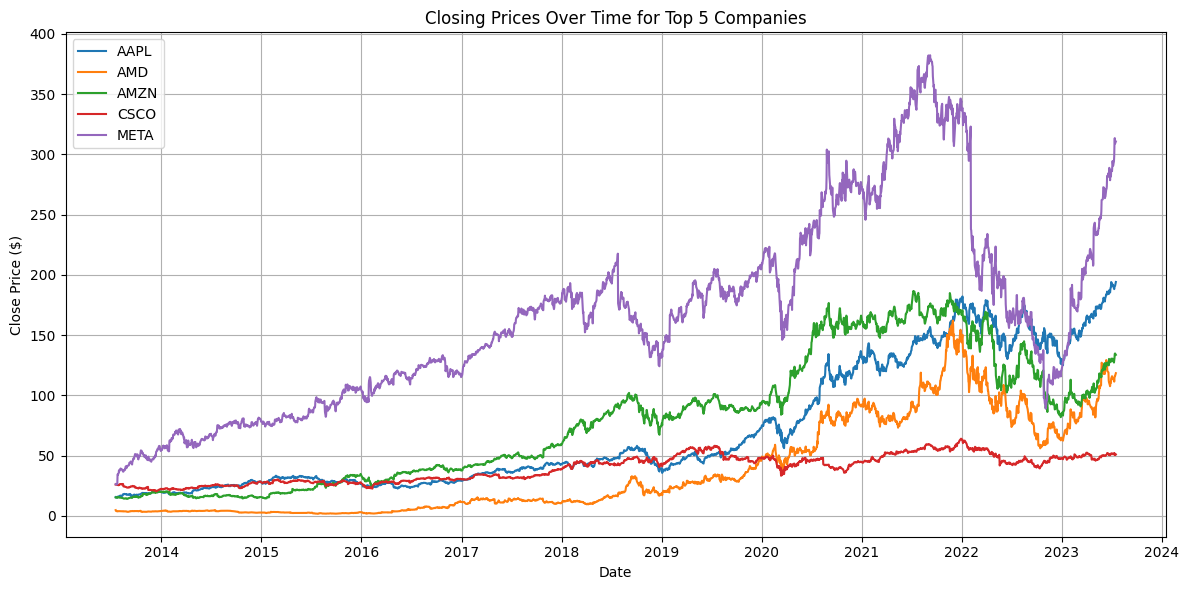

In [136]:
top_companies = df['company'].value_counts().head(5).index.tolist()
df_top = df[df['company'].isin(top_companies)]
plt.figure(figsize=(12, 6))
for company in top_companies:
    company_data = df_top[df_top['company'] == company]
    plt.plot(company_data['date'], company_data['close'], label=company)
plt.title("Closing Prices Over Time for Top 5 Companies")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
#Predicting AAPL's closing price 250 days into the future
df_aapl = df[df['company'] == 'AAPL'].copy()
# 2. Lag features
lag_features = ['open', 'high', 'low', 'volume', 'gap', 'volatility_5d']
for col in lag_features:
    df_aapl[f'{col}_lag1'] = df_aapl[col].shift(1)
# 3. Create target
df_aapl['target_close'] = df_aapl['close'].shift(-250)
features = [f'{col}_lag1' for col in lag_features]
X = df_aapl[features]
y = df_aapl['target_close']
# 5. Drop rows where target is missing (don't drop X NaNs)
valid = y.notna()
X = X.loc[valid]
y = y.loc[valid]
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 7. Train HistGradientBoostingRegressor (handles NaNs in X)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
# 8. Predict and evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 96.4349201062013
R²: 0.9625270195942718


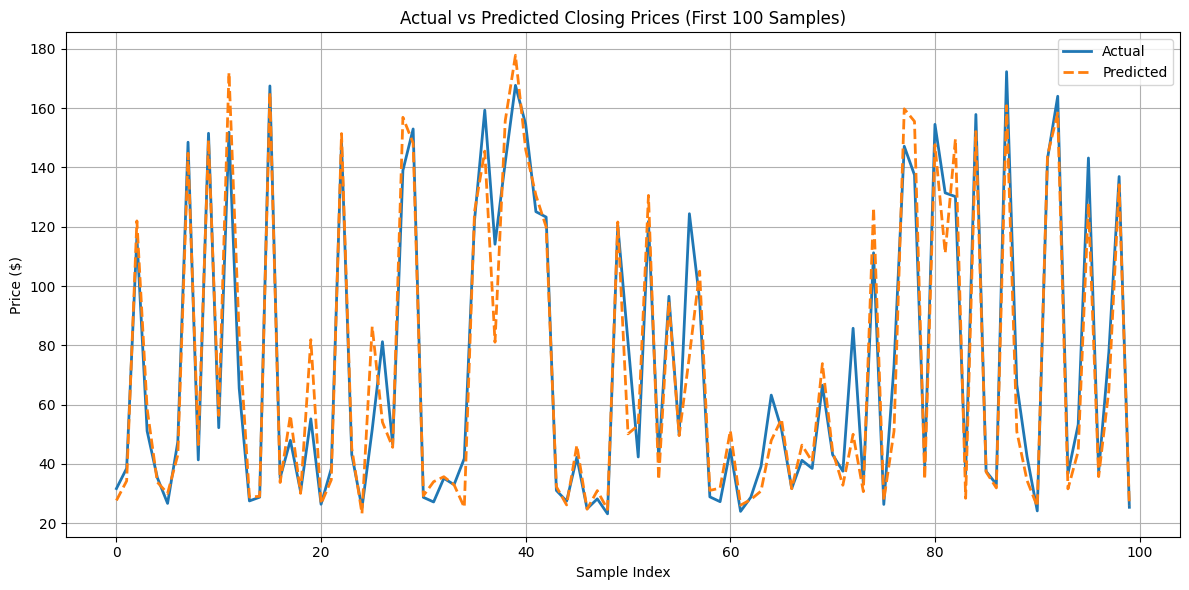

In [138]:
n = 100  # Number of points to show
plt.figure(figsize=(12, 6))
plt.plot(range(n), y_test[:n].values, label="Actual", linewidth=2)
plt.plot(range(n), y_pred[:n], label="Predicted", linewidth=2, linestyle='dashed')
plt.title("Actual vs Predicted Closing Prices (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
df = df.sort_values(by=['company', 'date'])
lag_features = ['open', 'high', 'low', 'volume', 'gap', 'volatility_5d']
for col in lag_features:
    df[f'{col}_lag1'] = df.groupby('company')[col].shift(1)
# 1-year forward return
df['target_return_1yr'] = df.groupby('company')['close'].shift(-250) / df['close'] - 1
# Final features
features = [f'{col}_lag1' for col in lag_features]
df_model = df.dropna(subset=features + ['target_return_1yr'])
# Add company indicator
X = pd.get_dummies(df_model[features + ['company']], columns=['company'])
y = df_model['target_return_1yr']
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
# Predict and evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


MSE: 0.3026682046148798
R^2: 0.5114461210154795


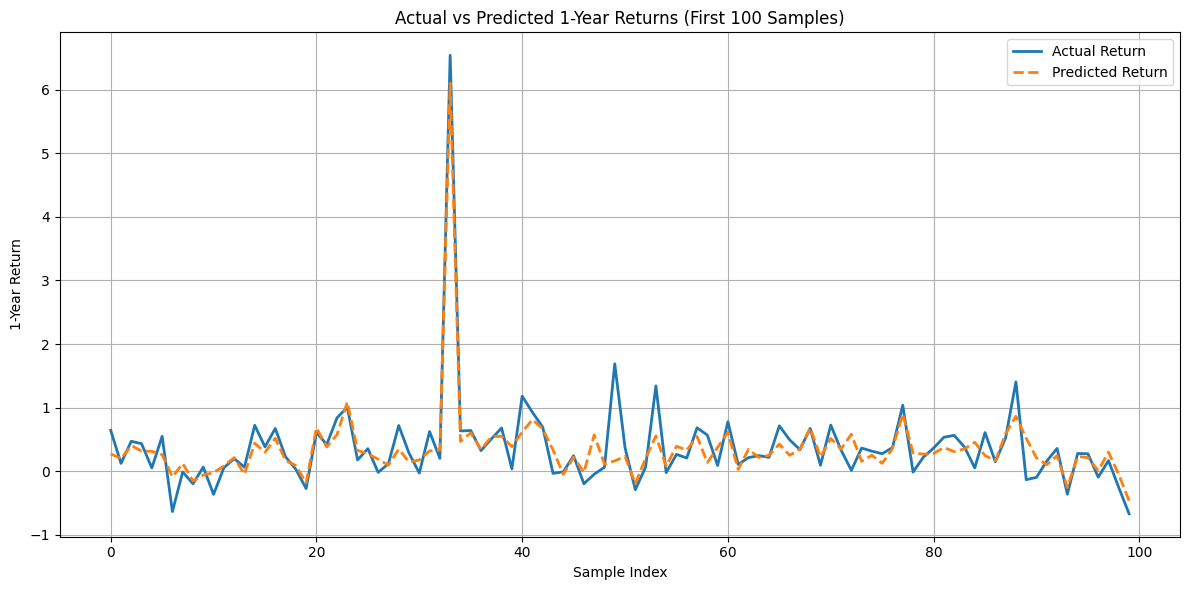

In [140]:
n = 100
plt.figure(figsize=(12, 6))
plt.plot(range(n), y_test[:n].values, label="Actual Return", linewidth=2)
plt.plot(range(n), y_pred[:n], label="Predicted Return", linewidth=2, linestyle='dashed')
plt.title("Actual vs Predicted 1-Year Returns (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("1-Year Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After our first run of regression we got some interesting results. On our first regression test we wanted to predict prices 250 days out. This gave us some important informatoin as our r2 score was very high. This very high for predicting stock prices. There is likely due to the sample of data being used and it being very similar not having much a shift so we are getting a dataset that is very similar. Stock prices are also affected by alot of outside factors which aren't factored into our dataset which is what makes prediciting prices so diffiucult. The next test we did was with predicting returns which is much more difficult than predicting prices. For this we were greated with a much lower r2 score and based on the graph of thedata you can see a lot of divergence. 

The impacts of this type of work is that it can help investors invest in the correct stock. This is one of the biggest bussineses in the world as stock prices change so often so hitting on the correct stock and making money is a very lucrative business. With doing that though if your predictions end up being incorrect than lots of money can be lost so its a very volatile bussiness. 